In [9]:
# 神经网络ANN
'''
conda create -n myenv python=3.8
conda activate myenv

conda install numpy pandas scikit-learn
conda install -c conda-forge tensorflow
'''
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model

In [10]:

# Load the data
df = pd.read_csv('clark-y-2.csv')

# Filter the data
filtered_df = df[
    (df['Reynold'] >= 0.1e5) & (df['Reynold'] <= 40e5) &  # 雷诺数范围
    (df['Mach'] >= 0.1) & (df['Mach'] <= 0.7) &            # 马赫数范围
    (df['Alpha'] >= -3) & (df['Alpha'] <= 15)              # 迎角范围
]

# Split the data into inputs (X) and outputs (y)
X = filtered_df[['Reynold', 'Mach', 'Alpha']].values
y = filtered_df[['cl', 'cd', 'cm']].values


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 29)

In [12]:
# Normalize the input data
scaler = MinMaxScaler()
scalery = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scalery.fit_transform(y_train)
y_test = scalery.transform(y_test)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='linear')  # 3 outputs: cl, cd, cm
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Train the model
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test,y_test), callbacks=[early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss}, MAE: {mae}")

# CNN2: Loss: 0.0032769939862191677, MAE: 0.038386013358831406
# CNN3: Loss: 0.0012407711474224925, MAE: 0.025044899433851242
# CNN4: Loss: 0.0007000479381531477, MAE: 0.017104944214224815

# R2-score
# Predict the test set
y_pred = model.predict(X_test)
y_pred = scalery.inverse_transform(y_pred)
y_test = scalery.inverse_transform(y_test)
r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
for i, r2 in enumerate(r2_scores):
    print(f"R² score for output {i+1}: {r2}")

Epoch 1/1000
125/125 [==============================] - 1s 3ms/step - loss: 1.0638 - mae: 0.8091 - val_loss: 1.0075 - val_mae: 0.7915
Epoch 2/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.8917 - mae: 0.7396 - val_loss: 0.7486 - val_mae: 0.6490
Epoch 3/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.5411 - mae: 0.5062 - val_loss: 0.4567 - val_mae: 0.4271
Epoch 4/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.4038 - mae: 0.3981 - val_loss: 0.4030 - val_mae: 0.3865
Epoch 5/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.3627 - mae: 0.3669 - val_loss: 0.3646 - val_mae: 0.3673
Epoch 6/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.3287 - mae: 0.3473 - val_loss: 0.3296 - val_mae: 0.3409
Epoch 7/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.3006 - mae: 0.3263 - val_loss: 0.3019 - val_mae: 0.3260
Epoch 8/1000
125/125 [==============================] - 0s 2ms

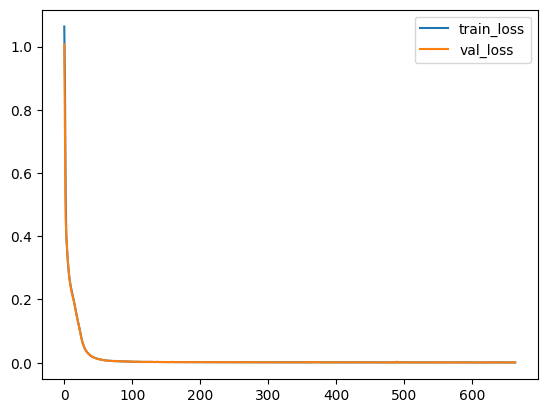

In [13]:
# plot the loss curve
losses = pd.DataFrame(history.history)
plt.plot(losses.index, losses['loss'], label='train_loss')
plt.plot(losses.index, losses['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [14]:
# Save the entire model to a file
model.save('clark-y-cnn.h5')

In [15]:
# Load the model from the file
model = load_model('clark-y-cnn.h5')

4/4 [==============================] - 0s 3ms/step


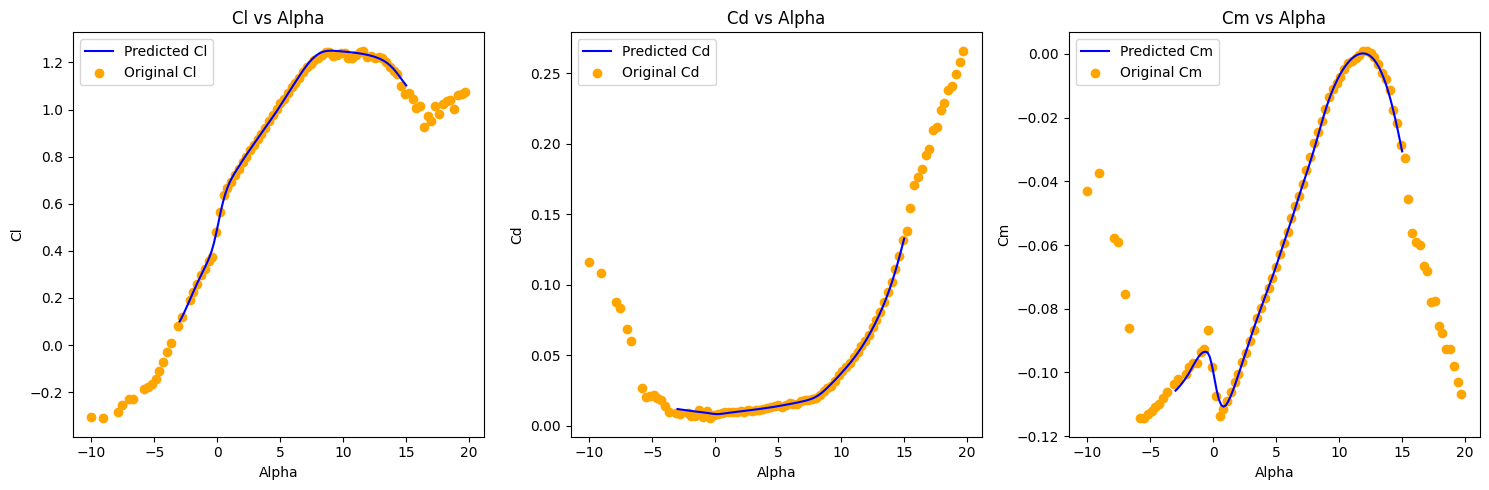

In [16]:
# Desired alpha
desire_re = 272631
desire_mach = 0.5
alpha_values = np.linspace(-3, 15, 100)  # 生成100个等间距的攻角值

# new X
new_X = np.array([[desire_re, desire_mach, alpha] for alpha in alpha_values])
new_X_scaled = scaler.transform(new_X)

# use model to predict new values
predictions = model.predict(new_X_scaled)
predictions = scalery.inverse_transform(predictions)

# extract predicted Cl, Cd, Cm
predicted_cl = predictions[:, 0]
predicted_cd = predictions[:, 1]
predicted_cm = predictions[:, 2]

# original data
filtered_df = df[(df['Reynold'] == desire_re) & (df['Mach'] == desire_mach)]
original_alpha = filtered_df['Alpha'].values
original_cl = filtered_df['cl'].values
original_cd = filtered_df['cd'].values
original_cm = filtered_df['cm'].values

# plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)    # Cl
plt.plot(alpha_values, predicted_cl, label='Predicted Cl', color='blue')
plt.scatter(original_alpha, original_cl, label='Original Cl', color='orange')
plt.title('Cl vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Cl')
plt.legend()

plt.subplot(1, 3, 2)    # Cd
plt.plot(alpha_values, predicted_cd, label='Predicted Cd', color='blue')
plt.scatter(original_alpha, original_cd, label='Original Cd', color='orange')
plt.title('Cd vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Cd')
plt.legend()

plt.subplot(1, 3, 3)    # Cm
plt.plot(alpha_values, predicted_cm, label='Predicted Cm', color='blue')
plt.scatter(original_alpha, original_cm, label='Original Cm', color='orange')
plt.title('Cm vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Cm')
plt.legend()

plt.tight_layout()
plt.show()